In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils

In [2]:
img_orig = cv2.imread('./images/03.jpg')

In [3]:
# cv2.namedWindow('original',cv2.WINDOW_NORMAL)
# cv2.imshow('priginal',img_orig)
# cv2.waitKey()
# cv2.destroyAllWindows()

### Scanning

**1. Resize the image and set aspect ratio**

In [4]:
def resize(image, width=500): # recommended to resize width to <500
    # get width and height
    h,w,c = image.shape

    height = int((h/w) * width) # aspect ratio is h/w. 
    size = (width, height)
    image = cv2.resize(image,(width, height))
    return image, size

In [5]:
img_re, size = resize(img_orig)
print(size)
cv2.imshow('Resized',img_re)
cv2.waitKey()
cv2.destroyAllWindows()

(500, 666)


**2. Image Processing**
1. Enhance
2. Grayscale
3. Blur
4. Edge Detect
5. Morphological transform
6. Contours
7. Find 4 Points

In [6]:
detail = cv2.detailEnhance(img_re,sigma_s= 20, sigma_r=0.15)
# sigma_s=standard dev, sigma_r=radius. Set them to medium range or img gets brighter
gray = cv2.cvtColor(detail, cv2.COLOR_BGR2GRAY) # GRAYSCALE IMAGE
blur = cv2.GaussianBlur(gray,(5,5),0) # blur to remove enhancements
# edge detect
edge_image = cv2.Canny(blur, 75,200) # thresholds
# morphological transform
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(edge_image, kernel, iterations=1)# increase intensity
# higher iterations=thicker line, brighter light
closing = cv2.morphologyEx(dilate,cv2.MORPH_CLOSE, kernel)

# find the contours
contours, hire = cv2.findContours(closing, 
                                  cv2.RETR_LIST,
                                  cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours,key=cv2.contourArea, reverse=True) # reverse=desc order
for contour in contours:
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02*peri,True)

    if len(approx) == 4:
        four_points = np.squeeze(approx)
        break

cv2.drawContours(img_re,[four_points],-1,(0,255,0),3)

# find four points for original image
multiplier = img_orig.shape[1] / size[0]
four_points_orig = four_points * multiplier
four_points_orig = four_points_orig.astype(int)

# cv2.imshow('resize contour',img_re)
# cv2.imshow('closing',closing)
# cv2.waitKey()
# cv2.destroyAllWindows()

In [7]:
from imutils.perspective import four_point_transform

In [8]:
wrap_image = four_point_transform(img_orig,four_points_orig)

In [9]:
cv2.imshow('wrap',wrap_image)
cv2.waitKey()
cv2.destroyAllWindows()

### Document Scanner function

In [10]:
def document_scanner(image):
    img_re, size = resize(image)
    
    detail = cv2.detailEnhance(img_re,sigma_s= 20, sigma_r=0.15)
    # sigma_s=standard dev, sigma_r=radius. Set them to medium range or img gets brighter
    gray = cv2.cvtColor(detail, cv2.COLOR_BGR2GRAY) # GRAYSCALE IMAGE
    blur = cv2.GaussianBlur(gray,(5,5),0) # blur to remove enhancements
    # edge detect
    edge_image = cv2.Canny(blur, 75,200) # thresholds
    # morphological transform
    kernel = np.ones((5,5),np.uint8)
    dilate = cv2.dilate(edge_image, kernel, iterations=1)# increase intensity
    # higher iterations=thicker line, brighter light
    closing = cv2.morphologyEx(dilate,cv2.MORPH_CLOSE, kernel)
    
    # find the contours
    contours, hire = cv2.findContours(closing, 
                                      cv2.RETR_LIST,
                                      cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours,key=cv2.contourArea, reverse=True) # reverse=desc order
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02*peri,True)
    
        if len(approx) == 4:
            four_points = np.squeeze(approx)
            break
    
    cv2.drawContours(img_re,[four_points],-1,(0,255,0),3)
    
    # find four points for original image
    multiplier = image.shape[1] / size[0]
    four_points_orig = four_points * multiplier
    four_points_orig = four_points_orig.astype(int)
    
    wrap_image = four_point_transform(image,four_points_orig)

    return wrap_image, four_points_orig, img_re, closing

In [37]:
img = cv2.imread('./images/033.jpg')
wrpimg, points, cnt_img, edgeimg = document_scanner(img)

In [38]:
cv2.imshow('original',img)
cv2.imshow('resize',cnt_img)
cv2.imshow('edge',edgeimg)
cv2.imshow('wrap',wrpimg)
cv2.waitKey()
cv2.destroyAllWindows

<function destroyAllWindows>

### Magic Color

In [13]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

In [39]:
rgb = cv2.cvtColor(wrpimg, cv2.COLOR_BGR2RGB)
magic_image = apply_brightness_contrast(rgb, 120, 0)
magic_image_c1 = apply_brightness_contrast(rgb, 0, 40)
magic_image_c2 = apply_brightness_contrast(rgb, 50, 40)

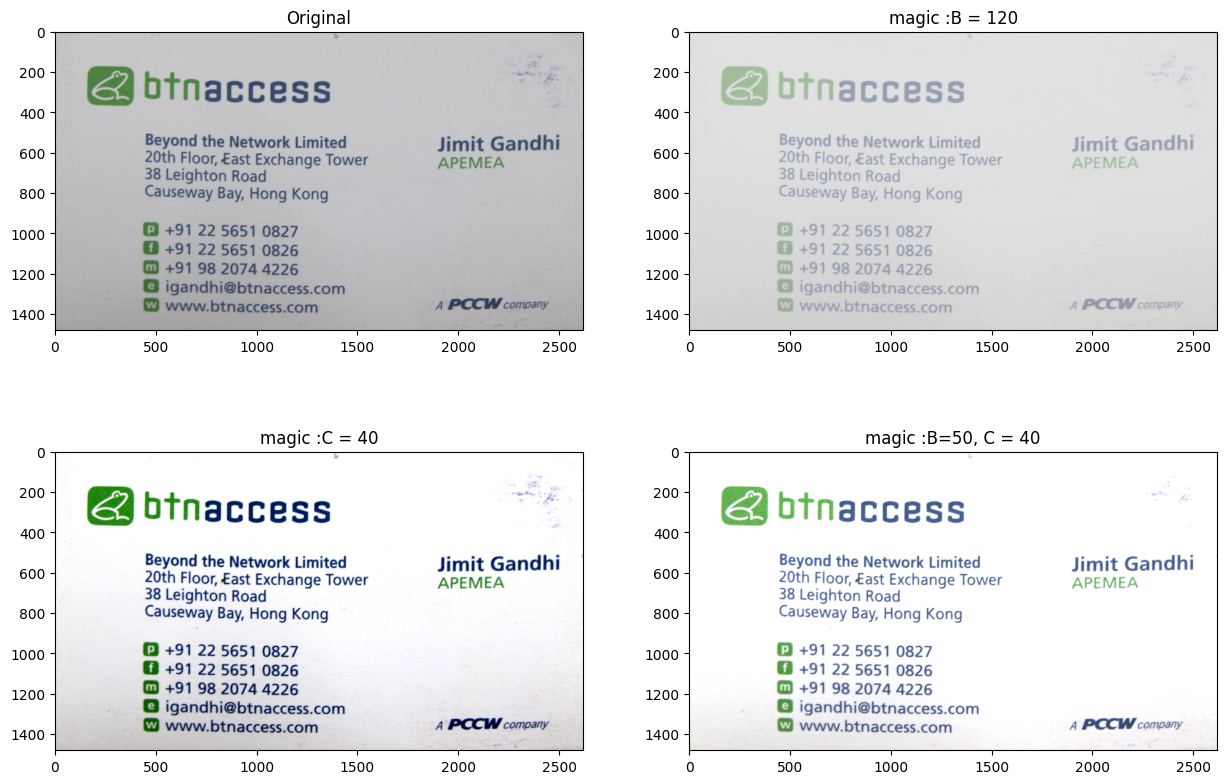

In [40]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1) # 1 row, 2 cols on first plot
plt.imshow(rgb)
plt.title('Original')

plt.subplot(2,2,2) # 1 row, 2 cols on second plot
plt.imshow(magic_image)
plt.title('magic :B = 120')

plt.subplot(2,2,3) # 1 row, 2 cols on second plot
plt.imshow(magic_image_c1)
plt.title('magic :C = 40')

plt.subplot(2,2,4) # 1 row, 2 cols on second plot
plt.imshow(magic_image_c2)
plt.title('magic :B=50, C = 40')
plt.show()

### Predictions

In [41]:
import predictions as pred

In [42]:
img_bb, results = pred.getPredictions(magic_image_c2)

@abtnaccess Beyond the Network Limited Jimit Gandhi 20th Floor, East Exchange Tower APEMEA 38 Leighton Road Causeway Bay, Hong Kong © 91 22 5651 0827 91 22 5651 0826 91 98 2074 4226 igandhi@btnaccess.com ompany www.btnaccess.com A POCW comp


In [44]:
cv2.namedWindow('predictions', cv2.WINDOW_NORMAL)
cv2.imshow('predictions',img_bb)
cv2.waitKey()
cv2.destroyAllWindows()

In [45]:
results

{'NAME': ['Kong'],
 'ORG': ['The', 'Limited'],
 'DES': [],
 'PHONE': ['', '91225651082791225651082691', '20744226'],
 'EMAIL': ['igandhi@btnaccess.com'],
 'WEB': ['www.btnaccess.com']}